In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import sys
sys.path.append("..")

import math

from scipy.stats import powerlaw

In [2]:
MNIST_path = "../datasets/MNIST/processed"

MNIST_train = torch.load(MNIST_path+"/training.pt")
MNIST_test = torch.load(MNIST_path + "/test.pt")

X_train_MNIST = MNIST_train[0].flatten(start_dim=1)/255
y_train_MNIST = MNIST_train[1]

X_test_MNIST = MNIST_test[0].flatten(start_dim=1)/255
y_test_MNIST = MNIST_test[1]

labels = ["pixel" +str(i) for i in range(784)]
labels.append("label")
labels.append("test/train")

X_train_MNIST_numpy = X_train_MNIST.numpy()
y_train_MNIST_numpy = np.empty((60000,1))
y_train_MNIST_numpy[:,0] = y_train_MNIST.numpy()

X_test_MNIST_numpy = X_test_MNIST.numpy()
y_test_MNIST_numpy = np.empty((10000,1))
y_test_MNIST_numpy[:,0] = y_test_MNIST.numpy()

trainLabels = np.empty((60000,1),dtype=object)
trainLabels[:,0] = np.array(['train' for i in range(60000)])
train = np.concatenate((X_train_MNIST_numpy, y_train_MNIST_numpy), axis=1)
train = np.concatenate((train, trainLabels), axis=1)

testLabels = np.empty((10000,1),dtype=object)
testLabels[:,0] = np.array(['test' for i in range(10000)])
test = np.concatenate((X_test_MNIST_numpy, y_test_MNIST_numpy), axis=1)
test = np.concatenate((test, testLabels), axis=1)

MNIST_df = pd.DataFrame(np.concatenate((train,test), axis=0), columns=labels)
MNIST_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label,test/train
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,train
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,train
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,train
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,train


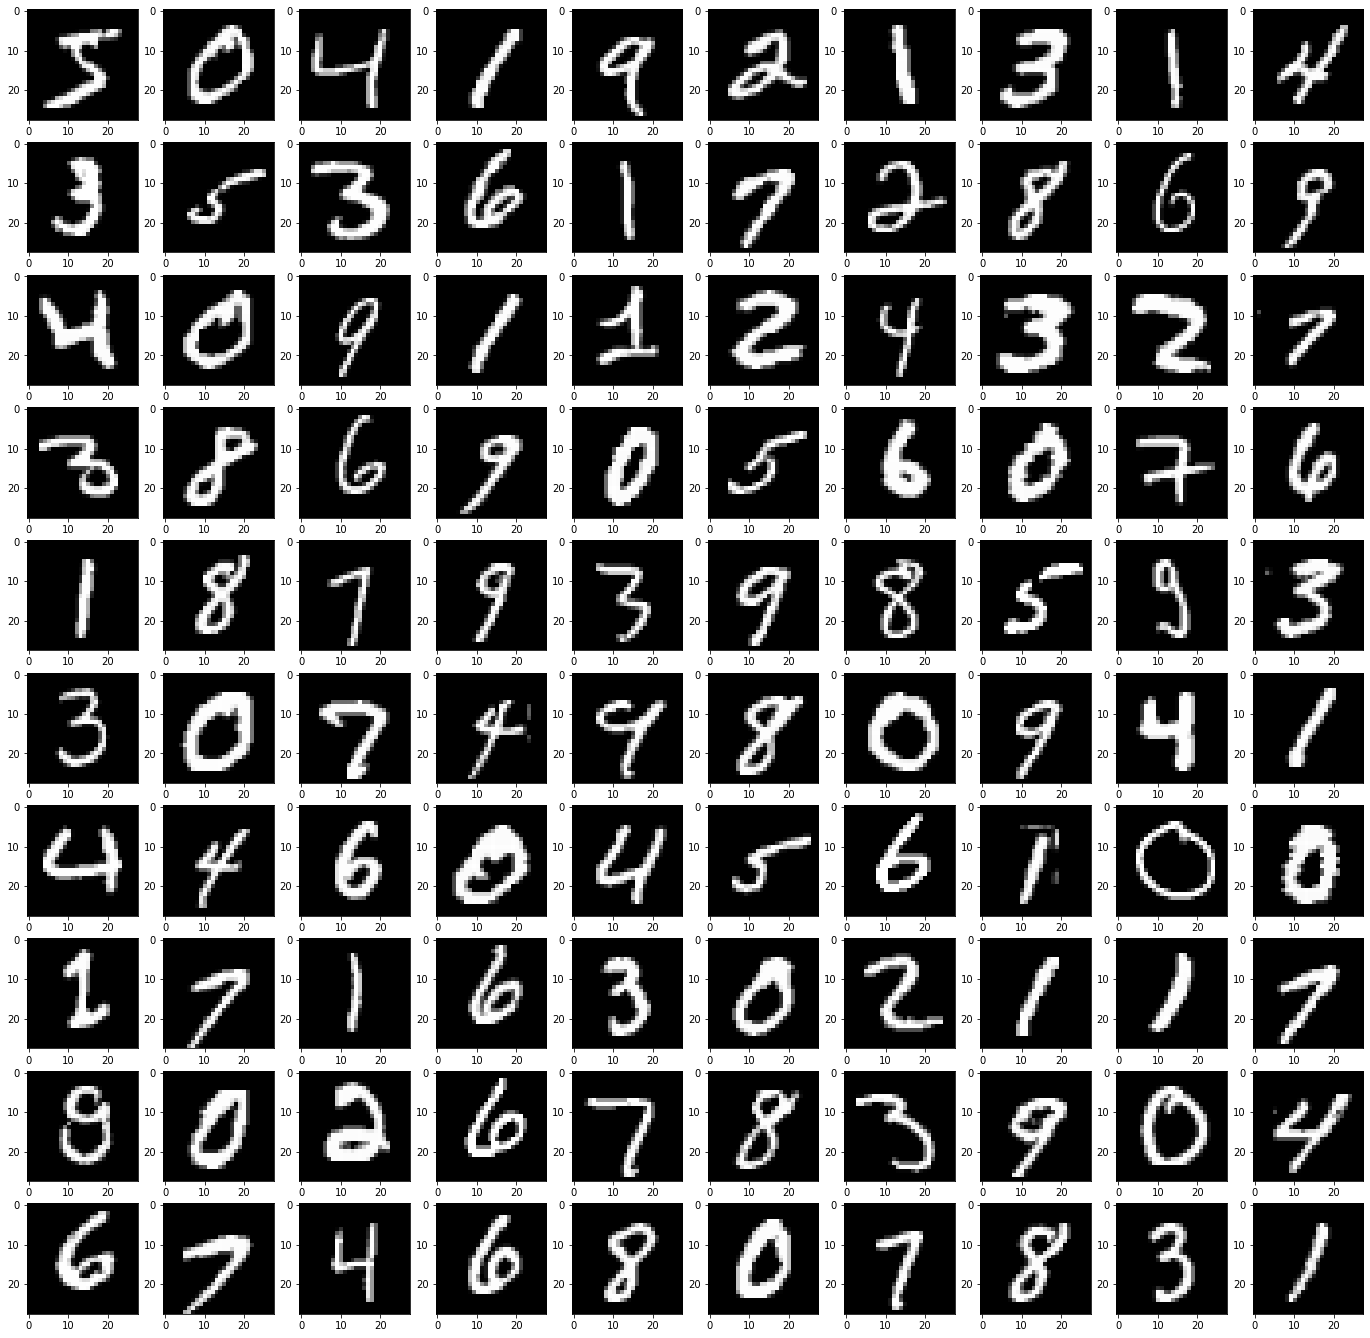

In [3]:
X = MNIST_df.drop(columns = ['label', 'test/train']).values

plt.rcParams['figure.figsize'] = [24, 24]
x_image = X.reshape((70000,28,28)).astype(float)
fig, axs = plt.subplots(10,10)
for i in range(100):
    axs[math.floor(i/10), i%10].imshow(x_image[i,:,:], cmap="gray")


In [4]:
def transform_4_and_9(x):
    if x == 4:
        return 0
    elif x == 9:
        return 1

### 2class MNIST datasets (IID, CI and SI)

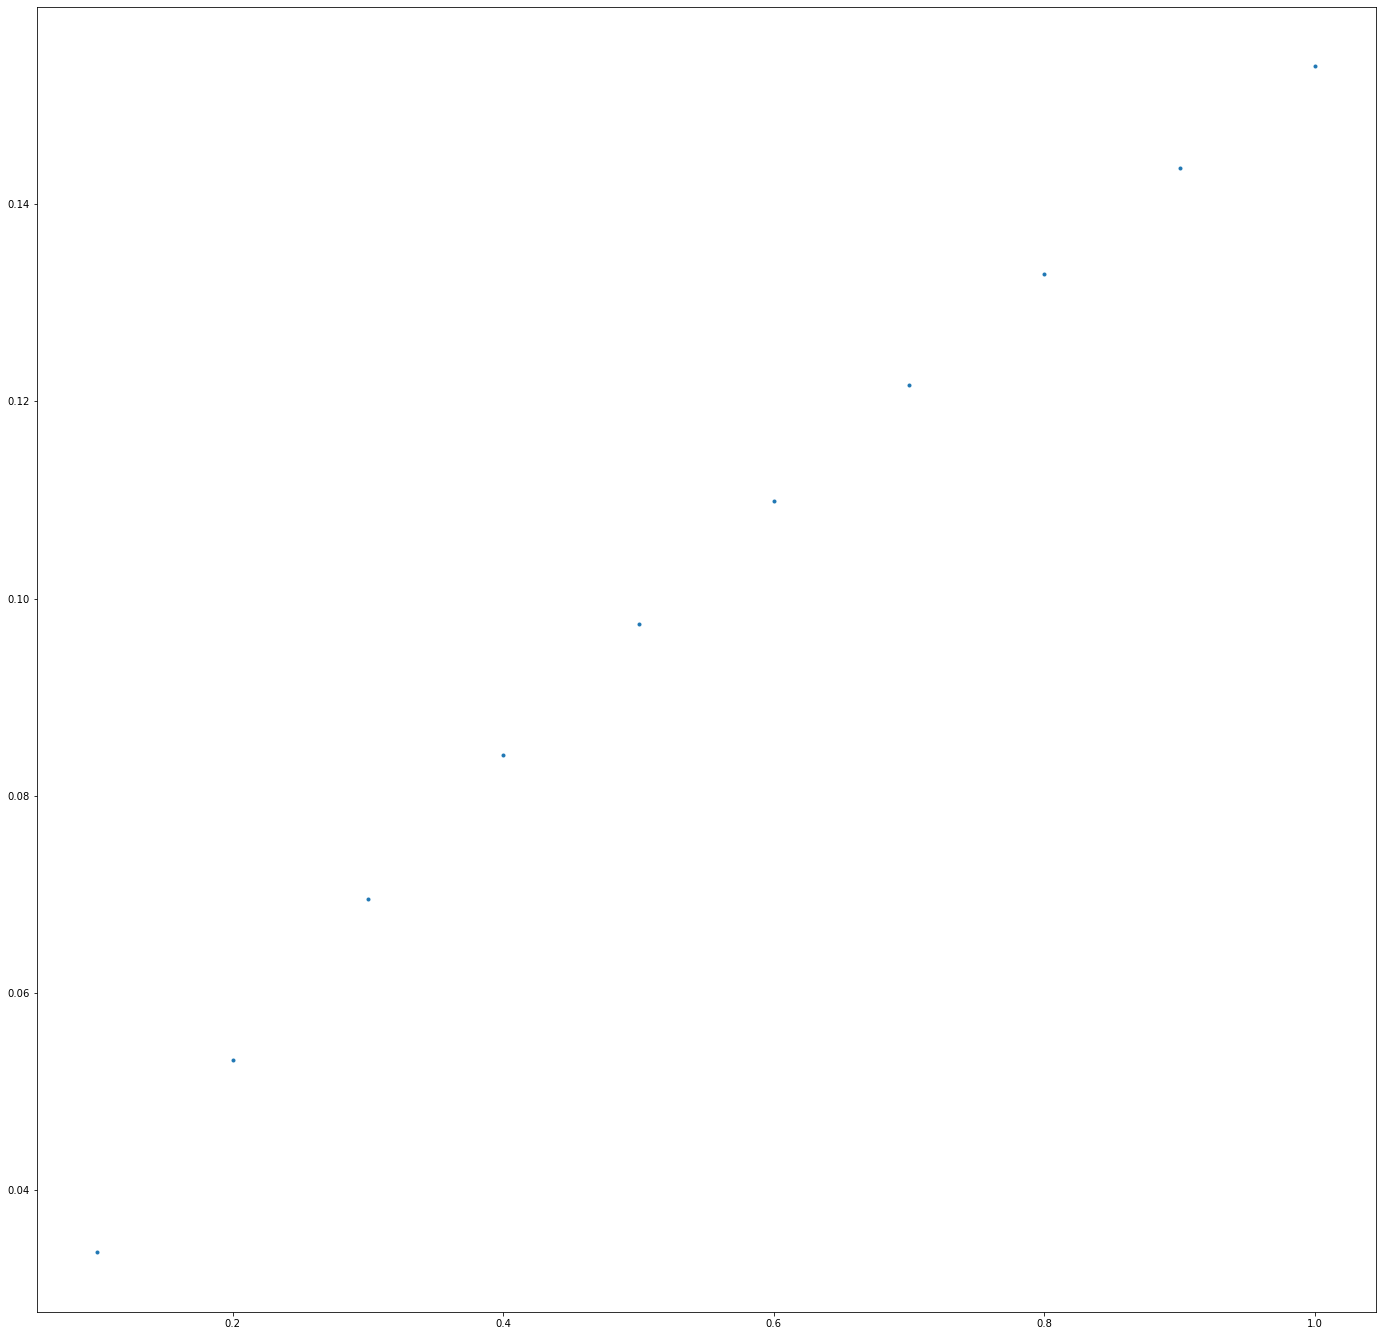

In [5]:
x = np.linspace(0.1, 1.0, 10)
pdf = np.array(powerlaw.pdf(x, a=1.66))
pdf_norm = pdf / pdf.sum()

plt.plot(x, pdf_norm,'.')

In [6]:
### select only the 4 and 9 images from the dataset
MNIST_2Class_df = MNIST_df.loc[(MNIST_df['label'] == 4) | (MNIST_df['label'] == 9)]
num_samples = MNIST_2Class_df.shape[0]
#print(num_samples)

### create uniform datasets
MNIST_2Class_df = MNIST_2Class_df.sample(frac=1).reset_index(drop=True)
# remap the 4 and 9 - labels to 0 and 1
MNIST_2Class_df['label'] = MNIST_2Class_df['label'].apply(transform_4_and_9)

uniform_sets = []
num_clients = 10
samples_per_client = math.floor(num_samples/num_clients)
for i in range(num_clients):
    client = MNIST_2Class_df.iloc[i* samples_per_client:(i+1) * samples_per_client]
    uniform_sets.append(client)

### create non-uniform datasets, sample wise
# create power-law distribution
x = np.linspace(0.1, 1.0, 10)
pdf = np.array(powerlaw.pdf(x, a=1.66))
pdf_norm = pdf / pdf.sum()
# sample according to power law
sample_nonIID_sets = []
begin_client_samples = 0
for i in range (num_clients):
    client_sample_amount = math.floor(pdf_norm[i] * num_samples)
    client = MNIST_2Class_df.iloc[begin_client_samples : begin_client_samples + client_sample_amount]
    begin_client_samples += client_sample_amount
    sample_nonIID_sets.append(client)
    
### create non-uniform datasets, class-wise
# split dataset in two for easier working
MNIST_4_df = MNIST_2Class_df.loc[(MNIST_2Class_df['label'] == 0)]
MNIST_9_df = MNIST_2Class_df.loc[(MNIST_2Class_df['label'] == 1)]


#shuffle both for good measure
MNIST_4_df = MNIST_4_df.sample(frac=1).reset_index(drop=True)
MNIST_9_df = MNIST_9_df.sample(frac=1).reset_index(drop=True)

total_samples_4 = MNIST_4_df.shape[0]
total_samples_9 = MNIST_9_df.shape[0]

class_nonIID_sets = []
begin_sample_4 = 0
begin_sample_9 = 0
for i in range(num_clients):
    amount_class_4 = math.floor(pdf_norm[i] * total_samples_4)
    amount_class_9 = math.floor(num_samples / 10) - amount_class_4
    tmp1 = MNIST_4_df.iloc[begin_sample_4:begin_sample_4+amount_class_4]
    tmp2 = MNIST_9_df.iloc[begin_sample_9:begin_sample_9+amount_class_9]
    client = pd.concat([tmp1, tmp2])
    client = client.sample(frac=1).reset_index(drop=True)
    class_nonIID_sets.append(client)
    begin_sample_4 += amount_class_4
    begin_sample_9 += amount_class_9

### Visuals on datasets

Text(0, 0.5, 'sample size')

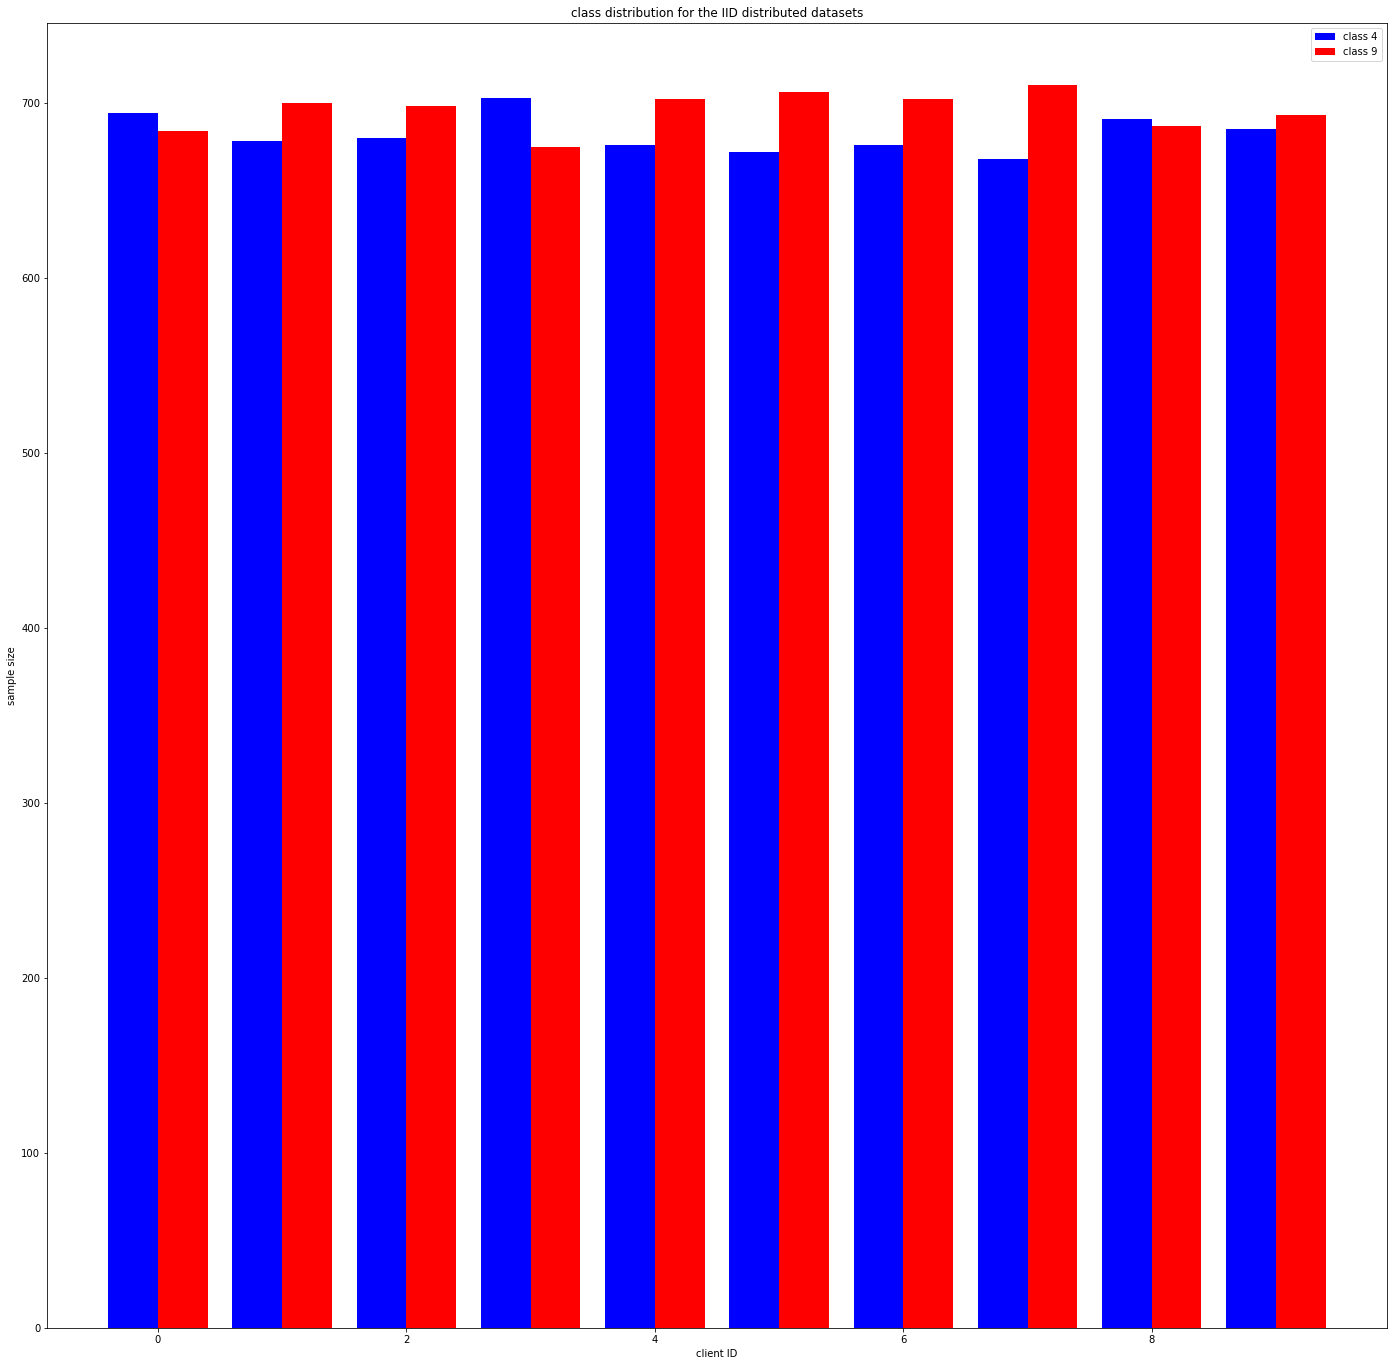

In [7]:
x = [4,9]
for i, client in enumerate(uniform_sets):
    #print(math.floor(i/5), i%5)
    samples_4 = client.loc[client['label'] == 0].shape[0]
    samples_9 = client.loc[client['label'] == 1].shape[0]
    plt.bar(i - 0.2, samples_4, width = 0.4, color = 'blue')
    plt.bar(i + 0.2, samples_9, width = 0.4, color = 'red')
plt.legend(['class 4', 'class 9'])
plt.title("class distribution for the IID distributed datasets")
plt.xlabel("client ID")
plt.ylabel("sample size")

Text(0, 0.5, 'sample size')

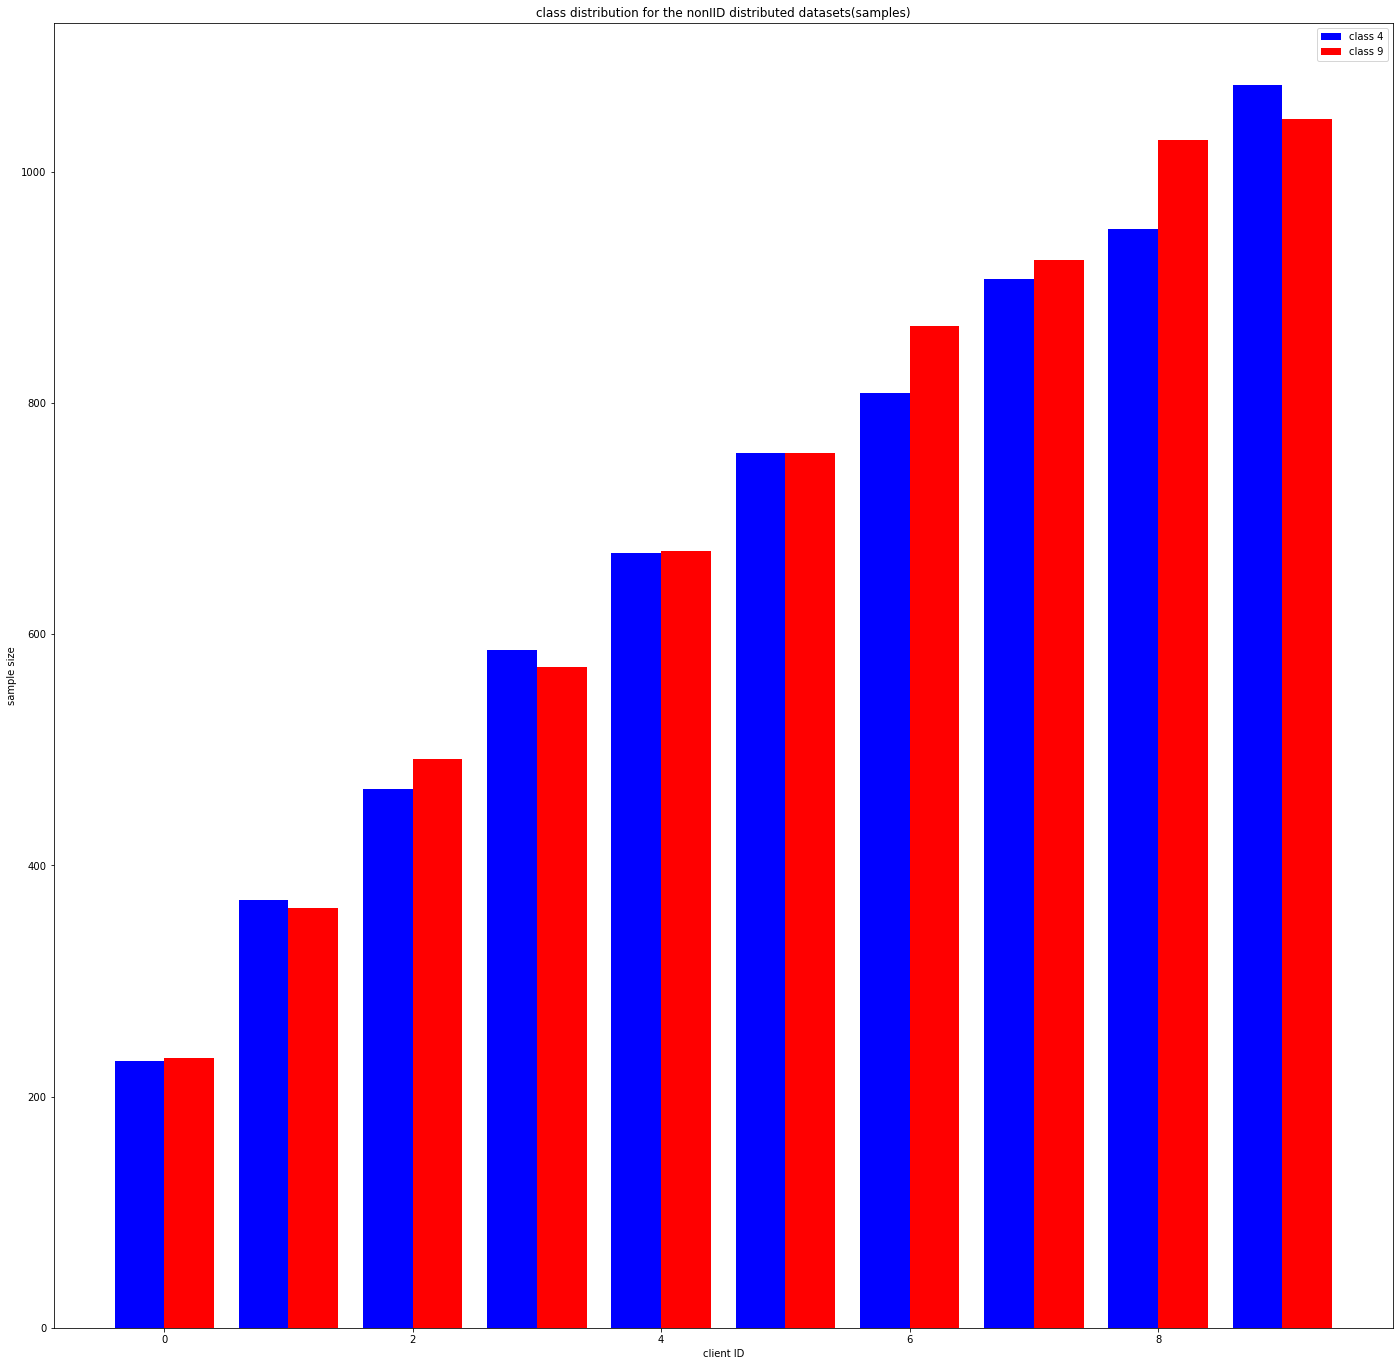

In [8]:
for i, client in enumerate(sample_nonIID_sets):
    #print(math.floor(i/5), i%5)
    samples_4 = client.loc[client['label'] == 0].shape[0]
    samples_9 = client.loc[client['label'] == 1].shape[0]
    plt.bar(i - 0.2, samples_4, width = 0.4, color = 'blue')
    plt.bar(i + 0.2, samples_9, width = 0.4, color = 'red')
plt.legend(['class 4', 'class 9'])
plt.title("class distribution for the nonIID distributed datasets(samples)")
plt.xlabel("client ID")
plt.ylabel("sample size")

Text(0, 0.5, 'sample size')

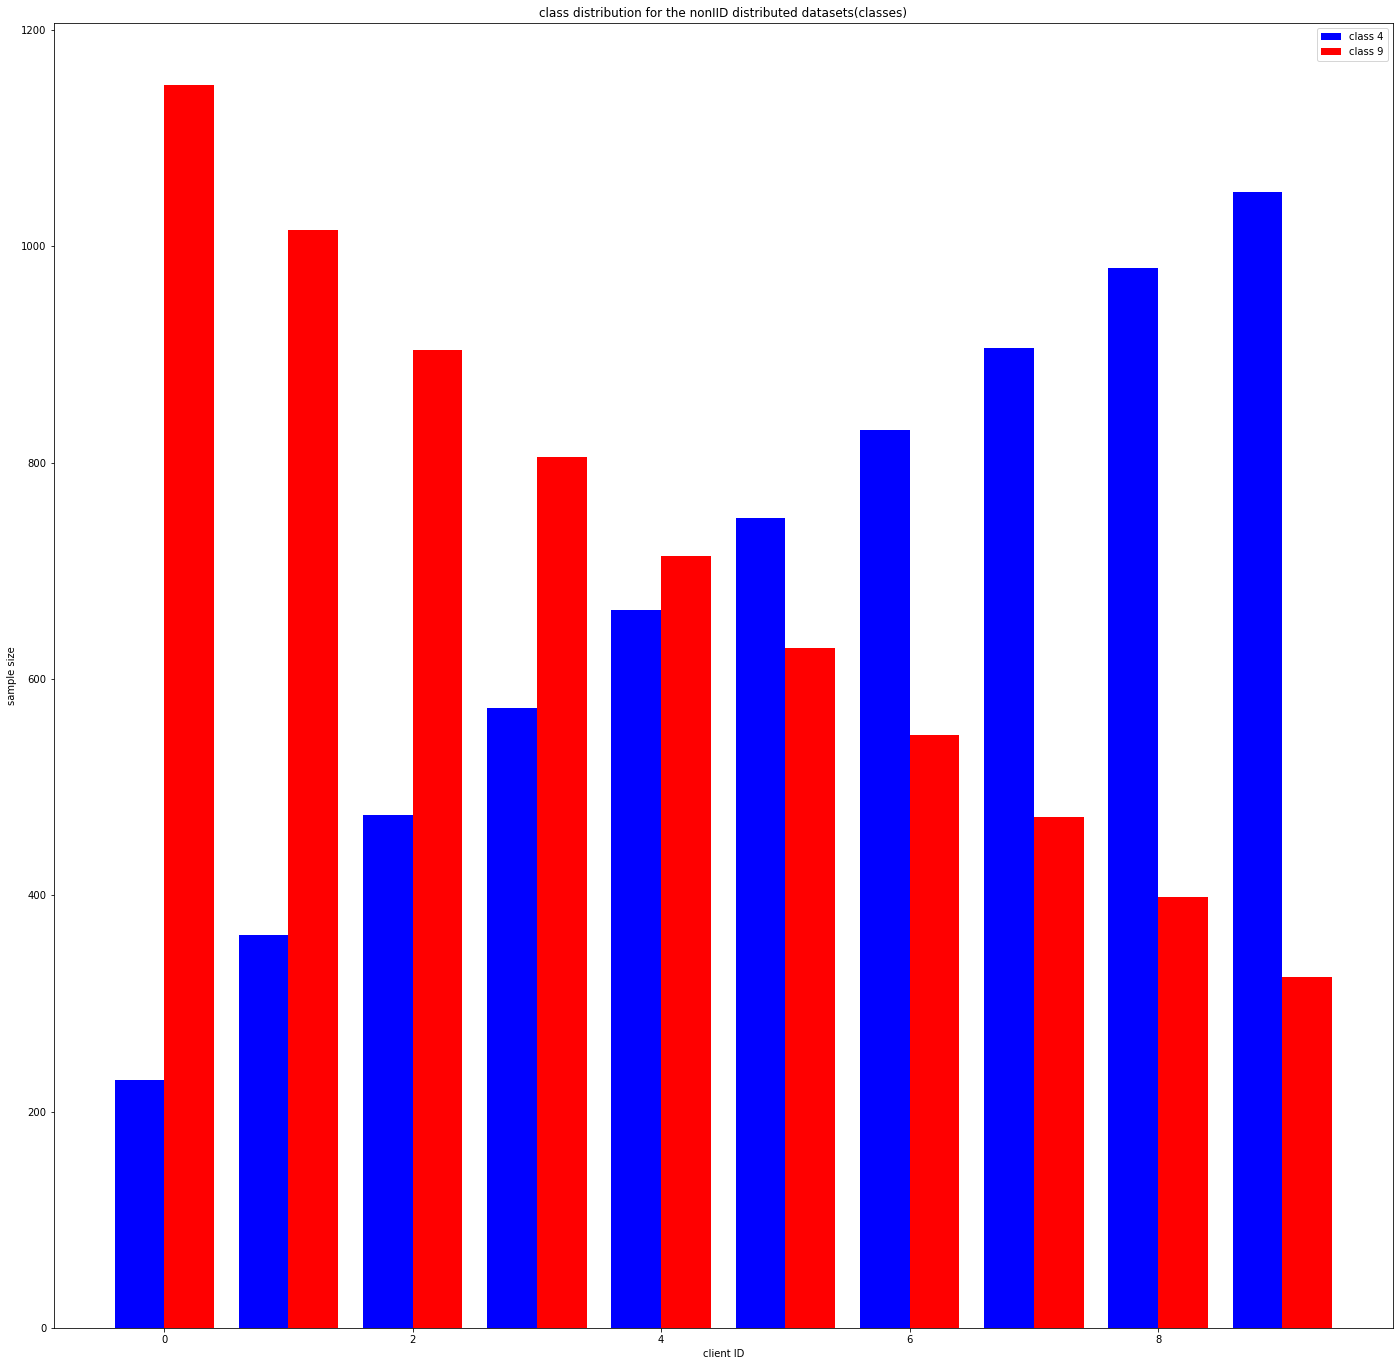

In [9]:
for i, client in enumerate(class_nonIID_sets):
    #print(math.floor(i/5), i%5)
    samples_4 = client.loc[client['label'] == 0].shape[0]
    samples_9 = client.loc[client['label'] == 1].shape[0]
    plt.bar(i - 0.2, samples_4, width = 0.4, color = 'blue')
    plt.bar(i + 0.2, samples_9, width = 0.4, color = 'red')
plt.legend(['class 4', 'class 9'])
plt.title("class distribution for the nonIID distributed datasets(classes)")
plt.xlabel("client ID")
plt.ylabel("sample size")

### Save to CSV

In [ ]:
for i, (client_IID, client_samples, client_classes) in \
enumerate(zip(uniform_sets, sample_nonIID_sets, class_nonIID_sets)):
    client_IID.to_csv("MNIST_2Class_IID_client" + str(i) + ".csv", index = False)
    client_samples.to_csv("MNIST_2Class_sample_imbalance_client" + str(i) + ".csv", index = False)
    client_classes.to_csv("MNIST_2Class_class_imbalance_client" + str(i) + ".csv", index = False)

### 4class MNIST (IID, CI and SI)
the 4 digits used for this are 2, 4, 8, 9. these were mapped to the labels 0, 1, 2, 3 so 2->0, 4->1,  8->2, 9->3

(10,)


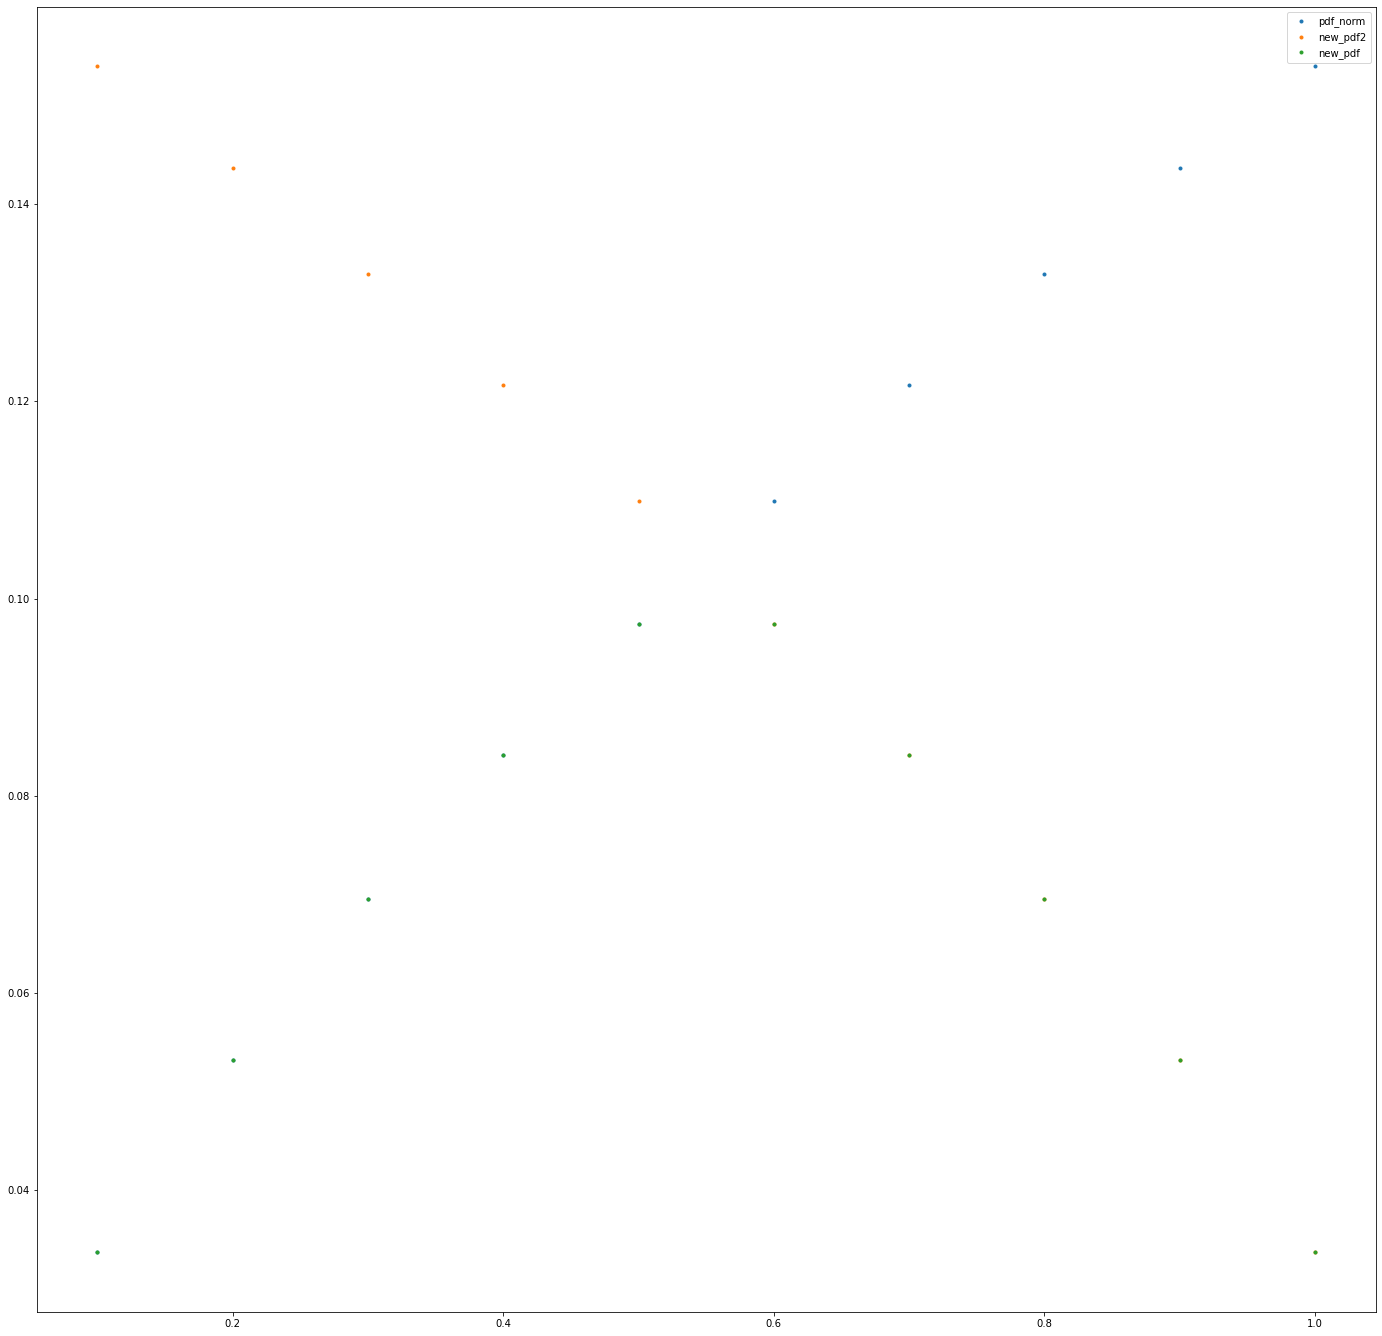

In [10]:
x = np.linspace(0.1, 1.0, 10)
pdf = np.array(powerlaw.pdf(x, a=1.66))
pdf_norm = pdf / pdf.sum()
new_pdf = [pdf_norm[i] for i in range(5)]
new_pdf2 = np.flip(pdf_norm)
for i in range(5,10):
    new_pdf.append(new_pdf2[i])

plt.plot(x,pdf_norm, '.')
plt.plot(x, new_pdf2 ,'.')
plt.plot(x,new_pdf, '.')
print(pdf_norm.shape)
plt.legend(["pdf_norm", "new_pdf2", "new_pdf"])

In [11]:
def remap(x):
    if x == 2:
        return 0
    elif x == 4:
        return 1
    elif x == 8:
        return 2
    elif x == 9:
        return 3

In [12]:
### select only the 2, 4, 8 and 9 images from the dataset
MNIST_4Class_df = MNIST_df.loc[(MNIST_df['label'] == 2) | (MNIST_df['label'] == 4)| (MNIST_df['label'] == 8)| (MNIST_df['label'] == 9)]
                                         
                                                                                 

### shuffle
MNIST_4Class_df = MNIST_4Class_df.sample(frac=1).reset_index(drop=True)
# remap to the correct labels
MNIST_4Class_df['label'] = MNIST_4Class_df['label'].apply(remap)

uniform_4Class_sets = []
num_clients = 10
num_samples = MNIST_4Class_df.shape[0]
samples_per_client = math.floor(num_samples/num_clients)
for i in range(num_clients):
    client = MNIST_4Class_df.iloc[i* samples_per_client:(i+1) * samples_per_client]
    uniform_4Class_sets.append(client)

### create non-uniform datasets, sample wise
# create power-law distribution
x = np.linspace(0.1, 1.0, 10)
pdf = np.array(powerlaw.pdf(x, a=1.66))
pdf_norm = pdf / pdf.sum()
# create a second distribution for the two other classes                                   
pdf2 = [pdf_norm[i] for i in range(5)]
pdf2_tmp = np.flip(pdf_norm)
for i in range(5,10):
    pdf2.append(pdf2_tmp[i])
pdf2 = np.array(pdf2)
pdf2_norm = pdf2/ pdf2.sum()             
# sample according to power law
sample_nonIID_4Class_sets = []
begin_client_samples = 0
for i in range (num_clients):
    client_sample_amount = math.floor(pdf_norm[i] * num_samples)
    client = MNIST_4Class_df.iloc[begin_client_samples : begin_client_samples + client_sample_amount]
    begin_client_samples += client_sample_amount
    sample_nonIID_4Class_sets.append(client)
    
### create non-uniform datasets, class-wise
# split dataset per class for easier working
MNIST_2_df = MNIST_4Class_df.loc[(MNIST_4Class_df['label'] == 0)]
MNIST_4_df = MNIST_4Class_df.loc[(MNIST_4Class_df['label'] == 1)]
MNIST_8_df = MNIST_4Class_df.loc[(MNIST_4Class_df['label'] == 2)]
MNIST_9_df = MNIST_4Class_df.loc[(MNIST_4Class_df['label'] == 3)]


#shuffle all for good measure
MNIST_2_df = MNIST_2_df.sample(frac=1).reset_index(drop=True)
MNIST_4_df = MNIST_4_df.sample(frac=1).reset_index(drop=True)
MNIST_8_df = MNIST_8_df.sample(frac=1).reset_index(drop=True)
MNIST_9_df = MNIST_9_df.sample(frac=1).reset_index(drop=True)

total_samples_2 = MNIST_2_df.shape[0]
total_samples_4 = MNIST_4_df.shape[0]
total_samples_8 = MNIST_8_df.shape[0]
total_samples_9 = MNIST_9_df.shape[0]

class_nonIID_4Class_sets = []
begin_sample_2 = 0
begin_sample_4 = 0
begin_sample_8 = 0
begin_sample_9 = 0
                                         
for i in range(num_clients):
    amount_class_2 = math.floor(pdf2_norm[i] * total_samples_2)
    amount_class_8 = math.floor(num_samples / 20) - amount_class_2
                                         
    amount_class_4 = math.floor(pdf_norm[i] * total_samples_4)
    amount_class_9 = math.floor(num_samples / 20) - amount_class_4
                                         
    tmp1 = MNIST_2_df.iloc[begin_sample_2:begin_sample_2+amount_class_2]
    tmp2 = MNIST_4_df.iloc[begin_sample_4:begin_sample_4+amount_class_4]
    tmp3 = MNIST_8_df.iloc[begin_sample_8:begin_sample_8+amount_class_8]
    tmp4 = MNIST_9_df.iloc[begin_sample_9:begin_sample_9+amount_class_9]
                                         
    client = pd.concat([tmp1, tmp2, tmp3, tmp4])
    client = client.sample(frac=1).reset_index(drop=True)
                                         
    class_nonIID_4Class_sets.append(client)
                                         
    begin_sample_2 += amount_class_2
    begin_sample_4 += amount_class_4
    begin_sample_8 += amount_class_8
    begin_sample_9 += amount_class_9

### Visuals

Text(0, 0.5, 'sample size')

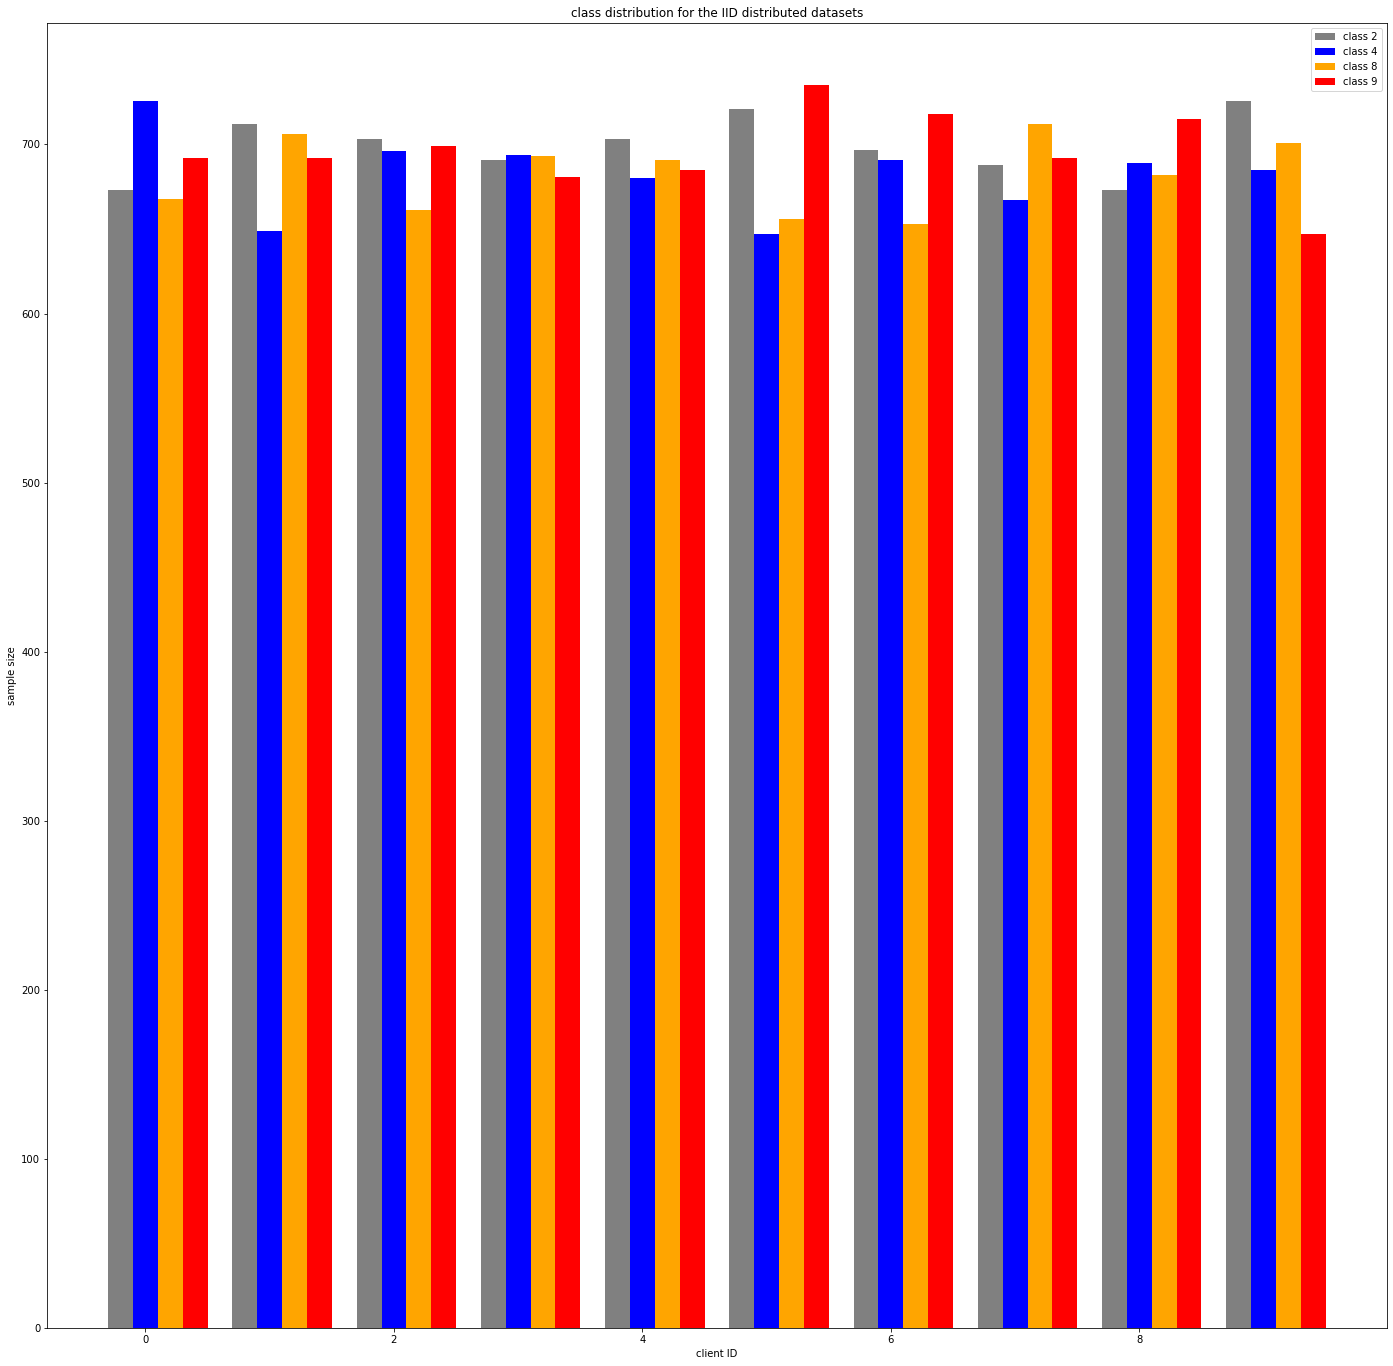

In [13]:
x = [2, 4, 8, 9]
for i, client in enumerate(uniform_4Class_sets):
    #print(math.floor(i/5), i%5)
    samples_2 = client.loc[client['label'] == 0].shape[0]
    samples_4 = client.loc[client['label'] == 1].shape[0]
    samples_8 = client.loc[client['label'] == 2].shape[0]
    samples_9 = client.loc[client['label'] == 3].shape[0]
    plt.bar(i- 0.2, samples_2, width = 0.2, color = 'gray')
    plt.bar(i , samples_4, width = 0.2, color = 'blue')
    plt.bar(i + 0.2, samples_8, width = 0.2, color = 'orange')
    plt.bar(i + 0.4, samples_9, width = 0.2, color = 'red')
plt.legend(['class 2', 'class 4','class 8', 'class 9'])
plt.title("class distribution for the IID distributed datasets")
plt.xlabel("client ID")
plt.ylabel("sample size")

Text(0, 0.5, 'sample size')

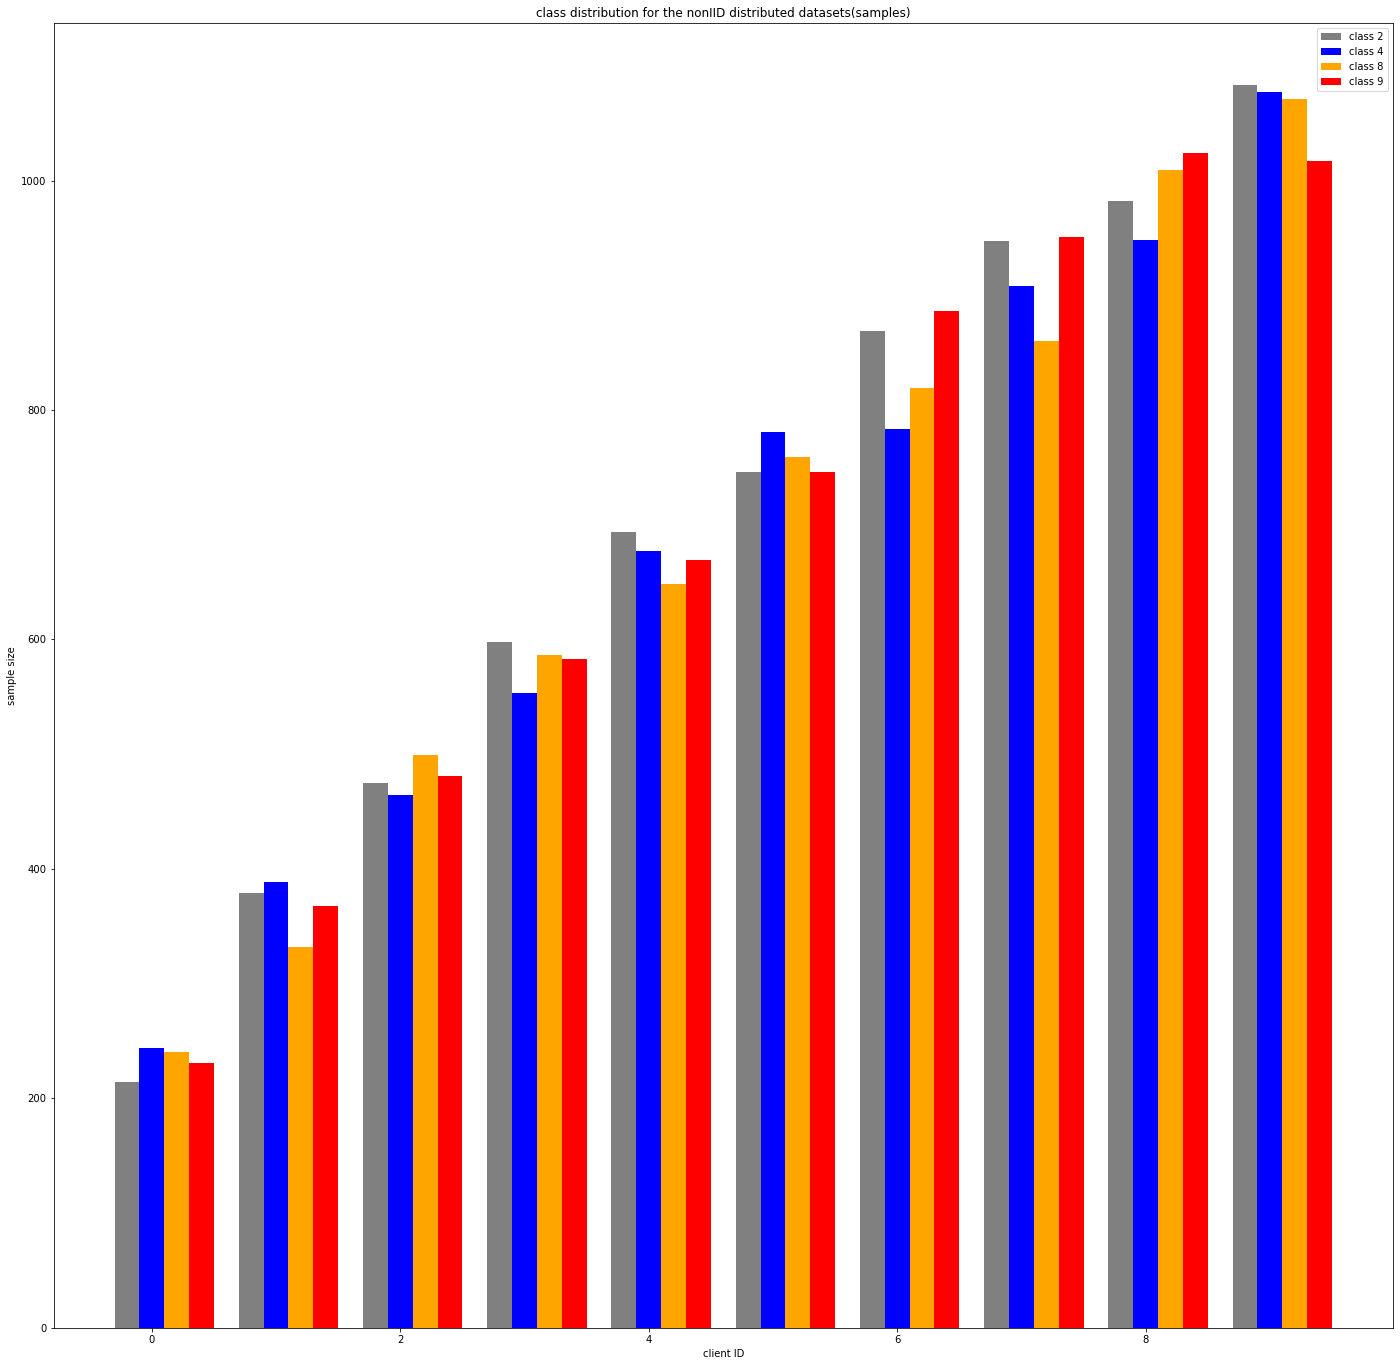

In [14]:
for i, client in enumerate(sample_nonIID_4Class_sets):
    #print(math.floor(i/5), i%5)
    samples_2 = client.loc[client['label'] == 0].shape[0]
    samples_4 = client.loc[client['label'] == 1].shape[0]
    samples_8 = client.loc[client['label'] == 2].shape[0]
    samples_9 = client.loc[client['label'] == 3].shape[0]
    
    plt.bar(i - 0.2, samples_2, width = 0.2, color = 'gray')
    plt.bar(i      , samples_4, width = 0.2, color = 'blue')
    plt.bar(i + 0.2, samples_8, width = 0.2, color = 'orange')
    plt.bar(i + 0.4, samples_9, width = 0.2, color = 'red')
plt.legend(['class 2', 'class 4', 'class 8', 'class 9'])
plt.title("class distribution for the nonIID distributed datasets(samples)")
plt.xlabel("client ID")
plt.ylabel("sample size")

Text(0, 0.5, 'sample size')

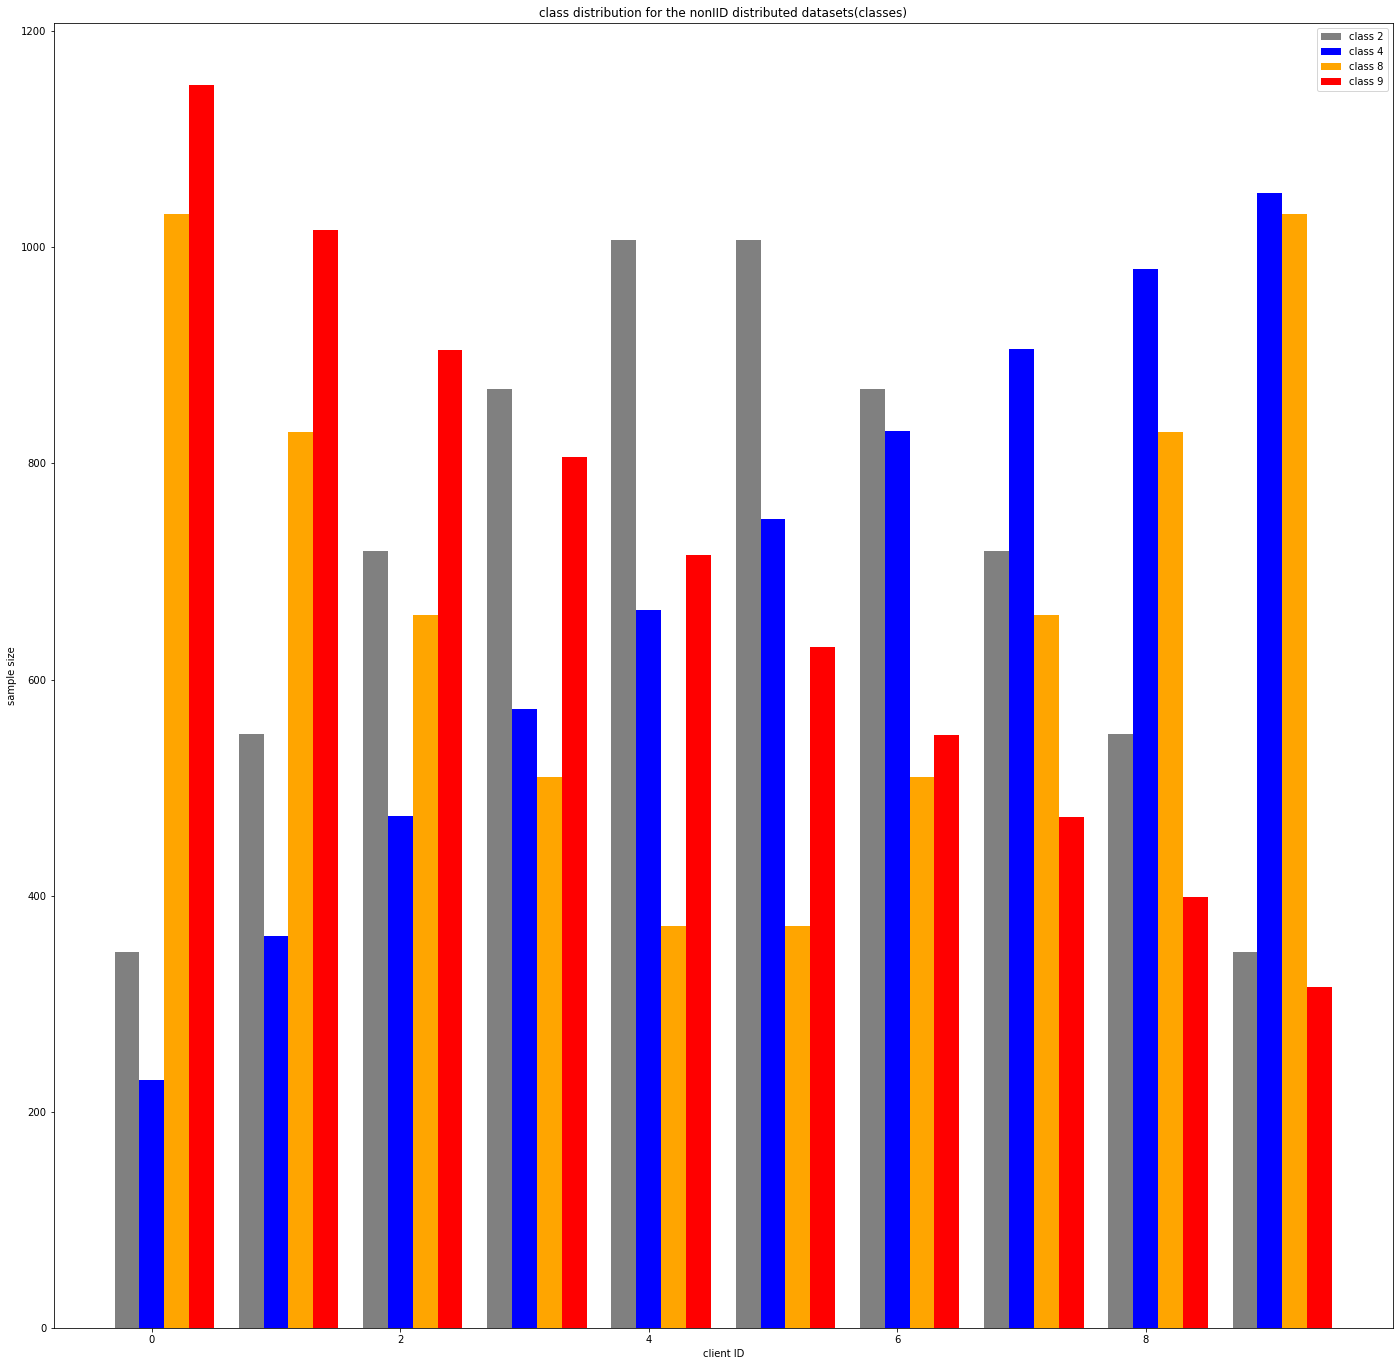

In [15]:
for i, client in enumerate(class_nonIID_4Class_sets):
    #print(math.floor(i/5), i%5)
    samples_2 = client.loc[client['label'] == 0].shape[0]
    samples_4 = client.loc[client['label'] == 1].shape[0]
    samples_8 = client.loc[client['label'] == 2].shape[0]
    samples_9 = client.loc[client['label'] == 3].shape[0]
    #print(samples_8)
    plt.bar(i - 0.2, samples_2, width = 0.2, color = 'gray')
    plt.bar(i      , samples_4, width = 0.2, color = 'blue')
    plt.bar(i + 0.2, samples_8, width = 0.2, color = 'orange')
    plt.bar(i + 0.4, samples_9, width = 0.2, color = 'red')
plt.legend(['class 2', 'class 4', 'class 8', 'class 9'])
plt.title("class distribution for the nonIID distributed datasets(classes)")
plt.xlabel("client ID")
plt.ylabel("sample size")

### to CSV

In [ ]:
for i, (client_IID, client_samples, client_classes) in \
enumerate(zip(uniform_4Class_sets, sample_nonIID_4Class_sets, class_nonIID_4Class_sets)):
    client_IID.to_csv("MNIST_4Class_IID_client" + str(i) + ".csv", index=False)
    client_samples.to_csv("MNIST_4Class_sample_imbalance_client" + str(i) + ".csv", index=False)
    client_classes.to_csv("MNIST_4Class_class_imbalance_client" + str(i) + ".csv", index=False)